# Modules

In [1]:
#!pip3 install ipympl

In [2]:
import gurobipy
from gurobipy import *

from random import randint
import pandas as pd
import numpy as np
import json

# for creating a responsive plot
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Input Data

In [5]:
# Opening JSON file
instance_name = "./instances/toy_instance"
f = open(instance_name+".json")
# returns JSON object as a dictionary
data = json.load(f)

In [6]:
## Problem's parameters :

I = len(data["staff"]) # Number of individuals
J = data["horizon"] # Horizon
P = len(data["jobs"]) # Number of projects
Q = len(data["qualifications"]) # Number of qualifications

In [7]:
# Projects
projects = pd.DataFrame()
for job in data["jobs"]:
    projects = pd.concat([projects,pd.DataFrame(job['working_days_per_qualification'], index=[job["name"]])],axis=0)
projects = projects.fillna(0)
projects = projects.astype('Int64')
projects


,A,B,C
Job1,1,1,1
Job2,1,2,0
Job3,1,0,2
Job4,0,2,1
Job5,0,0,2


In [8]:
# Personnel
personnel = pd.DataFrame(data['staff'])
personnel

,name,qualifications,vacations
0,Olivia,"[A, B, C]",[]
1,Liam,"[A, B]",[1]
2,Emma,[C],[2]


# Transform Data

In [9]:
## def functions from json
def vacations(collaborator, day):
    if day in collaborator["vacations"]:
        return 1
    else:
        return 0
def has_qualification(collaborator,qualification):
    # numbered collaborator
    if data["qualifications"][qualification] in data["staff"][collaborator]["qualifications"]:
        return 1
    else:
        return 0

def project_necessary_qualifications(project,qualification):
    if data["qualifications"][qualification] in data["jobs"][project]["working_days_per_qualification"].keys():
        return data["jobs"][project]["working_days_per_qualification"][data["qualifications"][qualification]]
    else:
        return 0
def gain(project):
    return project["gain"]

def date_rendu(project):
    return project["due_date"]

def penalite(project):
    return project["daily_penalty"]

date_delivery = {}
for p in range(P):
    date_delivery[p] = data["jobs"][p]["due_date"]

# Model

In [10]:
# Create a new model
m = Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-29


# Decision Variables

In [11]:
M = 10000
## Create variable rea (realisation of project)
X = {}
rea= {}
rea_project={}
lateness = {}
b = {}
b2 = {}
shift_change={}
project_began = {}

for p in range(P):
    lateness[p]=m.addVar(vtype=GRB.INTEGER,name="lateness["+str(p)+"]")
    b[p]=m.addVar(vtype=GRB.BINARY,name="binary_decision["+str(p)+"]")

    for j in range(J):
        rea_project[p,j]=m.addVar(vtype=GRB.BINARY,name="rea_project["+str(p)+","+str(j)+"]")
        project_began[p,j]=m.addVar(vtype=GRB.BINARY,name="project_began["+str(p)+","+str(j)+"]")
        
        for q in range(Q):
            rea[p,q,j]=m.addVar(vtype=GRB.BINARY,name="rea["+str(p)+","+str(q)+","+str(j)+"]")

            for i in range(I):
                X[i,j,p,q] = m.addVar(vtype=GRB.BINARY,name="X["+str(i)+","+str(j)+","+str(p)+","+str(q)+"]")
                b2[i,j,p,q] = m.addVar(vtype=GRB.BINARY,name="binary decision 2["+str(i)+","+str(j)+","+str(p)+","+str(q)+"]")
                shift_change[i,j,p,q] = m.addVar(vtype=GRB.BINARY,name="Shift Change ["+str(i)+","+str(j)+","+str(p)+","+str(q)+"]")

## Constraints

In [12]:
# Constraints
for j in range(J):
    for i in range(I):
        # Constraint for daily personnel allocation : only one project per person
        m.addConstr(quicksum(X[i,j,p,q] for p in range(P) for q in range(Q)) <= 1)
        for p in range(P):
            for q in range(Q):
                # Constraint for personnel qualifications : only affect a qualified person to a given task.
                m.addConstr(X[i,j,p,q] <= has_qualification(i,q))
                # Constraint for vacation : do not work on vacations
                m.addConstr(vacations(data["staff"][i],j) + X[i,j,p,q] <= 1)

for j in range(J-1):
    for i in range(I):
        for p in range(P):
            for q in range(Q):                                
                # constraint for max X_i,j+1,p,q - X_i,j,p,q
                m.addConstr(shift_change[i,j,p,q]>=0)
                m.addConstr(shift_change[i,j,p,q]>=X[i,j+1,p,q]-X[i,j,p,q])
                m.addConstr(shift_change[i,j,p,q]<=M*(1-b2[i,j,p,q]))
                m.addConstr(shift_change[i,j,p,q]<=X[i,j+1,p,q]-X[i,j,p,q]+M*b2[i,j,p,q])
                
for p in range(P):
    for j in range(J):
        # Constraint for project beginning 
        m.addConstr(quicksum(X[i,j_intermediate,p,q] for i in range(I) for q in range(Q) for j_intermediate in range(j+1)) <= M *project_began[p,j] - 1)
        m.addConstr(quicksum(X[i,j_intermediate,p,q] for i in range(I) for q in range(Q) for j_intermediate in range(j+1)) >= M *(project_began[p,j] - 1))
        
        
        # Constraint for project realisation
        m.addConstr(quicksum(rea[p,q,j] for q in range(Q)) - Q <= M*rea_project[p,j]-1)
        m.addConstr(quicksum(rea[p,q,j] for q in range(Q)) - Q >= M*(rea_project[p,j]-1))
        for q in range(Q):
            m.addConstr(quicksum(X[i,j_intermediate,p,q] for i in range(I) for j_intermediate in range(j+1)) - project_necessary_qualifications(p,q)  <= M*rea[p,q,j]-1)
            m.addConstr(quicksum(X[i,j_intermediate,p,q] for i in range(I) for j_intermediate in range(j+1)) - project_necessary_qualifications(p,q)  >= M*(rea[p,q,j]-1))
        
    # Constraint for lateness in [0, Horizon - date_delivery]     
    m.addConstr( lateness[p]>= J - quicksum(rea_project[p,j] for j in range(J))-date_delivery[p])
    m.addConstr( lateness[p]<= J - quicksum(rea_project[p,j] for j in range(J))-date_delivery[p]+M*b[p])
    m.addConstr( lateness[p]>= 0)
    m.addConstr( lateness[p]<= M*(1-b[p]))

## objective function

In [13]:
## Set objective function

## Fonction obj 1: Maximize profits
profits = LinExpr()
for p in range(P):
    ### profits is the sum of the gain of each project minus the penalty for each day of delay 
    penal = penalite(data["jobs"][p])*lateness[p]
    profits += gain(data["jobs"][p])*rea_project[p,J-1] - penal

## Fonction obj 2: Minimize the number of shift changes
changements_affectations = LinExpr()
    
changements_affectations += -quicksum(shift_change[i,j,p,q] for i in range(I) for j in range(J-1) for p in range(P) for q in range(Q))

    
## Fonction obj 3: Minimize the number of days of delay
diff = LinExpr()

for p in range( P):
    for j in range(J):
        diff += project_began[p,j] - rea_project[p,j]

m.setObjectiveN(profits, 0,GRB.MAXIMIZE)
m.setObjectiveN(changements_affectations,1, GRB.MAXIMIZE)
m.setObjectiveN(-diff,2, GRB.MAXIMIZE)

m.ModelSense = GRB.MAXIMIZE

#Update Modèle
m.update()

## Optimize the model

In [14]:
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1455 rows, 810 columns and 5655 nonzeros
Model fingerprint: 0x476566e5
Variable types: 0 continuous, 810 integer (805 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
---------------------------------------------------------------------------

Optimize a model with 1455 rows, 8

# Mdel Status

In [15]:
print("Model status is: " + str(m.status))
if m.status == GRB.INFEASIBLE:
    print("\n The Problem has NO Solution!!!")
elif m.status == GRB.UNBOUNDED:
    print("\n The Problem is Bounded!!!")
else:
    print('The Problem has a Solution')

Model status is: 2
The Problem has a Solution


# Solutions visualisation

In [16]:
data_sol = json.loads(m.getJSONSolution())
print("The model has ", data_sol["SolutionInfo"]["SolCount"], " solution(s)")

The model has  8  solution(s)


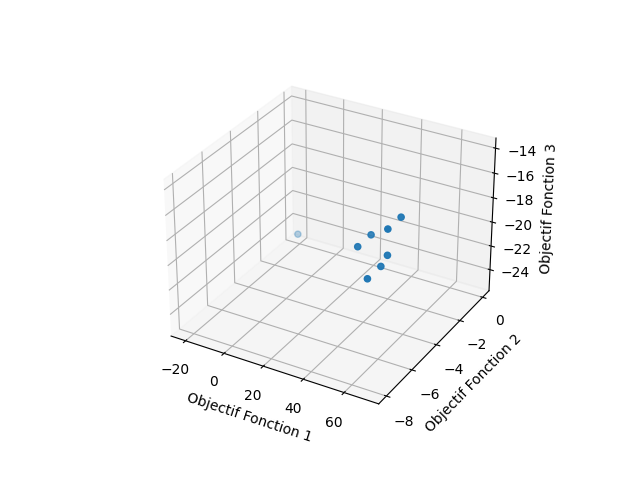

In [17]:
# Plotting the solutions with regards to the objective functions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =[row[0] for row in data_sol["SolutionInfo"]["PoolObjVal"]]
y =[row[1] for row in data_sol["SolutionInfo"]["PoolObjVal"]]
z =[row[2] for row in data_sol["SolutionInfo"]["PoolObjVal"]]
ax.scatter(x, y, z)

ax.set_xlabel('Objectif Fonction 1')
ax.set_ylabel('Objectif Fonction 2')
ax.set_zlabel('Objectif Fonction 3')

plt.show()

In [18]:
# Planning
def get_planning():
    # Dataframe with affectations
    planning = pd.DataFrame(np.nan, columns = ["day_"+str(i) for i in range(J)],index = [i for i in range(I)])
    for i in range(I):
        for j in range(J):
            for p in range(P):
                for q in range(Q):
                        if X[i,j,p,q].x > 0:
                            planning.iloc[i,j] = q
    ## colors cells with regard to project
    color_pro = {}
    for i in range(P):
        color_pro[i] = '#%06X' % randint(0, 0xFFFFFF)

    df_color = pd.DataFrame(np.nan, columns = ["day_"+str(i) for i in range(J)],index = [i for i in range(I)])
    for i in range(I):
        for j in range(J):
            for p in range(P):
                for q in range(Q):
                        if X[i,j,p,q].x > 0:
                            df_color.iloc[i,j] = color_pro[p]
    df_color = df_color.applymap(lambda x: 'background-color: {}'.format(x))
    def highlight_1(x):
        return pd.DataFrame(df_color.values, columns=x.columns)
    planning = planning.astype('Int64')
    planning = planning.style.apply(highlight_1,axis=None)
    # Mapping colors to projects
    proj_col = pd.DataFrame()
    i=0
    for project in projects.index:
        proj_col = pd.concat([proj_col,pd.DataFrame({'project':project,'color': 'background-color: ' + color_pro[i]},index=[i])], axis=0)
        i+=1
    def highlight_2(x):
        return x
    proj_col = proj_col.style.apply(highlight_2,axis=None, subset=['color'])
    return planning, proj_col

planning, proj_col = get_planning()

In [19]:
planning

,day_0,day_1,day_2,day_3,day_4
0,0,1,1,0,
1,1,,1,1,0
2,2,2,,2,2


In [20]:
proj_col

,project,color
0,Job1,background-color: #9BDE88
1,Job2,background-color: #A547E0
2,Job3,background-color: #1C3DB2
3,Job4,background-color: #31C827
4,Job5,background-color: #37081B


In [21]:
# select only non dominated solutions
def get_non_dominated_solutions(m):
    # get the solutions
    data = json.loads(m.getJSONSolution())
    # get the objective values
    obj_val = data["SolutionInfo"]["PoolObjVal"]
    # get the number of solutions
    nb_sol = data["SolutionInfo"]["SolCount"]
    # get the number of objectives
    nb_obj = len(obj_val[0])
    # get the index of the solutions that are non dominated
    non_dominated_solutions = []
    for i in range(nb_sol):
        dominated = False
        for j in range(nb_sol):
            if i != j:
                if all(obj_val[i][k] >= obj_val[j][k] for k in range(nb_obj)):
                    dominated = True
        if not dominated:
            non_dominated_solutions.append(i)
    return non_dominated_solutions


In [22]:
get_non_dominated_solutions(m)

[4, 6, 7]

### systèmes de choix/préférence

In [23]:
dico = {}
for count,value in enumerate(data_sol["SolutionInfo"]["PoolObjVal"]):
    dico[count]=value

In [25]:
dico

{0: [70, -6, -14],
 1: [70, -7, -14],
 2: [70, -7, -16],
 3: [67, -7, -17],
 4: [67, -8, -17],
 5: [56, -6, -16],
 6: [56, -7, -16],
 7: [-21, 0, -25]}

In [24]:
def bordas_ranking(dico):
    df = pd.DataFrame.from_dict(dico, orient='index', columns=['gain','shift_change','diff'])
    df['default_rank'] = df['gain'].rank(method='min', ascending=False)
    df['shift_change_rank'] = df['shift_change'].rank(method='min', ascending=False)
    df['diff_rank'] = df['diff'].rank(method='min', ascending=False)
    df['borda'] = df['default_rank'] + df['shift_change_rank'] + df['diff_rank']

    df = df.sort_values(by = 'borda', ascending = True)
    return df


def somme_ponderee(dico,poids1=1,poids2=0.5,poids3=0.5):
    for i in dico.keys():
        dico[i] = dico[i],np.sum(dico[i]*np.array([poids1,poids2,poids3]))
    return {k: v[0] for k, v in sorted(dico.items(), key=lambda item: item[0])}

def fonction_seuil(dico,seuil,fonction_a_appeler):
    max_gain = max(np.array(list(dico.values())).T[0])
    list_to_keep = {}
    for key, values in enumerate(dico.values()):
        if values[0] >=max_gain*seuil:
            list_to_keep[key] = dico[key]
    print(list_to_keep)
    return fonction_a_appeler(list_to_keep)

In [22]:
fonction_seuil(dico,0.99,somme_ponderee)

{0: [70, -6, -14], 1: [70, -7, -14], 2: [70, -7, -16]}


{0: [70, -6, -14], 1: [70, -7, -14], 2: [70, -7, -16]}

### a few tests/trucs à enregistrer/pour afficher des résultats, etc ....

In [23]:
for i in range(m.SolCount):  
    m.Params.SolutionNumber = i
    m.write("solutions/"+instance_name+"/"+f"{i}.sol")

In [24]:
big_total = 0
for p in range(P):
    big_total += gain(data["jobs"][p])
    
print(big_total)

80


In [25]:
print('Number of solutions found: ' + str(m.SolCount))
for sol in range(m.SolCount):
    print(sol)
    m.Params.SolutionNumber = sol
    print(m.PoolObjVal)
print('')
print('')
for sol in range(m.SolCount):
    m.Params.SolutionNumber = sol
    m.setParam(GRB.Param.SolutionNumber, sol)
    values = m.Xn
    print("solution number", sol )
    print(values)


Number of solutions found: 8
0
70.0
1
70.0
2
70.0
3
67.0
4
67.0
5
56.0
6
56.0
7
-21.0


solution number 0
[-0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, -0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, -0.0, -0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, -0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, -0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, -0.0, -0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 1.0, 1.0, 1.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, 0.0, -0.0, 1.0, -0.0, 0.0, 1.0, 0

In [26]:
for i in range(I):
    for j in range(J):
        for p in range(P):
            for q in range(Q):
                    if X[i,j,p,q].x > 0:
                        print(" X[",i,",",j,",",p,",",q,"] = ".format(X[i,j,p,q].x), X[i,j,p,q].x)
                        print(" ")


 X[ 0 , 0 , 0 , 0 ] =  1.0
 
 X[ 0 , 1 , 3 , 1 ] =  1.0
 
 X[ 0 , 2 , 3 , 1 ] =  1.0
 
 X[ 0 , 3 , 1 , 0 ] =  1.0
 
 X[ 1 , 0 , 0 , 1 ] =  1.0
 
 X[ 1 , 2 , 1 , 1 ] =  1.0
 
 X[ 1 , 3 , 1 , 1 ] =  1.0
 
 X[ 1 , 4 , 2 , 0 ] =  1.0
 
 X[ 2 , 0 , 0 , 2 ] =  1.0
 
 X[ 2 , 1 , 3 , 2 ] =  1.0
 
 X[ 2 , 3 , 2 , 2 ] =  1.0
 
 X[ 2 , 4 , 2 , 2 ] =  1.0
 
